In [2]:
import datautils
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [3]:
# Read in the data
tic = time.clock()
X_train, y_train, labels = datautils.get_data(num_classes=10, per_class=25, res=256)
toc = time.clock()
print "Read {} images in {:5} seconds".format(X_train.shape[0], toc - tic)
print X_train.shape
print y_train.shape

Read 250 images in 4.843168 seconds
(250, 256, 256, 1)
(250,)


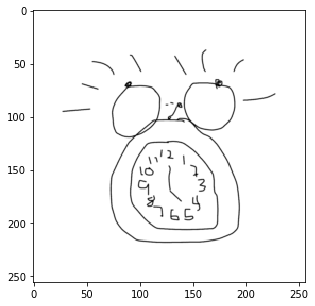

alarm clock


In [4]:
# Plot a random image
sample = np.random.randint(X_train.shape[0])
plt.imshow(X_train[sample].reshape(256, 256))
plt.show()
print labels[y_train[sample]]

In [5]:
def model(X, y):
    c1 = tf.layers.conv2d(X, 16, [3, 3], padding='SAME') # 256 x 256 x 16
    b1 = tf.layers.batch_normalization(c1)
    h1 = tf.nn.relu(b1)
    p1 = tf.layers.max_pooling2d(h1, [2, 2], [2, 2]) # 128 x 128 x 16
    
    c2 = tf.layers.conv2d(p1, 32, [3, 3], padding='SAME') # 128 x 128 x 32
    b2 = tf.layers.batch_normalization(c2)
    h2 = tf.nn.relu(b2)
    p2 = tf.layers.max_pooling2d(h2, [2, 2], [2, 2]) # 64 x 64 x 32
    
    c3 = tf.layers.conv2d(p2, 64, [3, 3], padding = 'SAME') # 64 x 64 x 64
    b3 = tf.layers.batch_normalization(c3)
    h3 = tf.nn.relu(b3)
    p3 = tf.layers.max_pooling2d(h3, [2, 2], [2, 2]) # 32 x 32 x 64
    
    p4 = tf.layers.average_pooling2d(p3, [32, 32], [1, 1]) # 1 x 1 x 64
    
    p4_flat = tf.reshape(p4, [-1, 64])
    y_out = tf.layers.dense(p4_flat, 250)
    
    return y_out
    
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 256, 256, 1])
y = tf.placeholder(tf.int64, [None])

y_out = model(X, y)
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,250), logits=y_out))
optimizer = tf.train.AdamOptimizer()

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

In [ ]:
iterations = 10

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_out,1), y), tf.float32))
    print "Variables initialized"
    feed_dict = {X : X_train, y: y_train}
    for i in range(iterations):
        loss, acc, _ = sess.run([mean_loss, accuracy, train_step], feed_dict=feed_dict)
        print "Loss: {}, accuracy: {}".format(loss, acc)

Variables initialized
Loss: 17.3282337189, accuracy: 0.0
Loss: 12.0415840149, accuracy: 0.10000000149
Loss: 8.87904548645, accuracy: 0.0
Loss: 6.95240831375, accuracy: 0.0839999988675
Loss: 5.76939678192, accuracy: 0.10000000149
Loss: 4.99638414383, accuracy: 0.10000000149
